# Biweekly Report 3

# Fine-Tuning BERT for Paraphrasing

## Jake Watts

In this section of the report, I fine-tune a BERT model on the Microsoft Research Paraphrase Corpus (MRPC). The corpus consists of pairs of sentences taken from the news. Each pair is labeled as "semantically equivalent" or "not semantically equivalent". The dataset is part of the GLUE (General Language Understanding Evaluation) benchmarks which is a collection of resources to evaluate the performance of language understanding systems.

The goal in fine-tuning BERT will be to create a model that can correctly identify whether or not the pairs of sentences are semantically equivalent and the performance will be evaluated by looking at the accuracy as well as a confusion matrix on the test data. The results from this model can also be used as a baseline to compare to more advanced models such as ELECTRA which is implemented on the same data by Johnny in his section of the report.

Sources:

https://www.microsoft.com/en-us/download/details.aspx?id=52398

https://www.tensorflow.org/text/tutorials/fine_tune_bert?hl=ca

https://github.com/nyu-mll/GLUE-baselines

https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3

https://arxiv.org/abs/1810.04805

In [1]:
pip install -q -U tensorflow-text==2.7.3

     |████████████████████████████████| 4.9 MB 7.2 MB/s 
     |████████████████████████████████| 495.0 MB 34 kB/s 
     |████████████████████████████████| 463 kB 47.1 MB/s 
     |████████████████████████████████| 1.3 MB 36.3 MB/s 


In [2]:
pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 7.8 MB/s 
     |████████████████████████████████| 1.2 MB 38.9 MB/s 
     |████████████████████████████████| 352 kB 50.9 MB/s 
     |████████████████████████████████| 99 kB 9.1 MB/s 
     |████████████████████████████████| 47.7 MB 1.5 MB/s 
     |████████████████████████████████| 234 kB 53.9 MB/s 
     |████████████████████████████████| 1.1 MB 37.6 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 596 kB 50.2 MB/s 


In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

Loading the BERT model from Tensorflow Hub. The weights are the weights released by the original authors of the paper "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding". The model was pre-trained using the English language from Wikipedia and BooksCorpus.

In [4]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

## Exploratory Data Analysis + Pre-Processing

Loading the MRPC in from TensorFlow datasets.

In [5]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       batch_size=-1)

Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete5GODBI/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete5GODBI/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete5GODBI/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


The data is split into a training, testing and validation set.

In [ ]:
list(glue.keys())

['test', 'train', 'validation']

Below we can see the size of the training, testing and validation sets.

In [13]:
print("Train data size:", len(glue['train']['idx']))
print("Validation data size:", len(glue['validation']['idx']))
print("Test data size:", len(glue['test']['idx']))

Train data size: 3668
Validation data size: 408
Test data size: 1725


The data consists of sentence pairs (sentence1 and sentence2) along with a label representing semantic equivalence (0 for not equivalent and 1 for equivalent) and an index.

In [ ]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [ ]:
info.features['label'].names

['not_equivalent', 'equivalent']

Here is an example of the first sentence pair in the training set. The label indicates that these two sentences are not semantically equivalent.

In [37]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[3].numpy()}")

idx      : 2896
label    : 1
sentence1: b"The 2002 second quarter results don 't include figures from our friends at Compaq ."
sentence2: b'The year-ago numbers do not include figures from Compaq Computer .'


From the label distribution below we can see that the labels are not balanced. The training data consists of approximately 2500 equivalent sentence pairs and approximately 1200 non-equivalent sentence pairs.

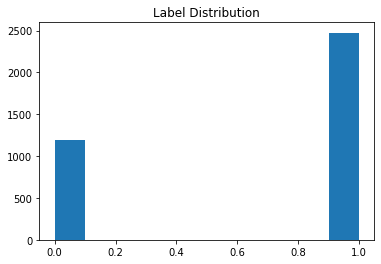

In [34]:
x = glue['train']['label'].numpy()

plt.hist(x)
plt.title("Label Distribution")
plt.show()

While looking at the test data I noticed that the labels were all -1 rather than 0 or 1. I believe this is an error and am not sure why the TensorFlow data is like this.

In [9]:
glue['test']['label']

<tf.Tensor: shape=(1725,), dtype=int64, numpy=array([-1, -1, -1, ..., -1, -1, -1])>

To make it so that I could evaluate on the testing data, I read in the test data from the following URL. The sentences are the same, however the ID numbers are different and the labels are 0 or 1 rather than -1.

In [ ]:
from urllib.request import urlopen

MRPC_TEST = "https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt"
data = urlopen(MRPC_TEST)

Here I extract the correct labels from the text.

In [ ]:
test_label = []

for line in data:
  decoded_line = line.decode("utf-8")
  if decoded_line.split("\t")[0] == '1' or decoded_line.split("\t")[0] == '0':
    input_label = int(decoded_line.split("\t")[0])
    test_label.append(input_label)

I then order the labels in the same order as the TensorFlow testing data and convert the labels to a tensor to match the format of the rest of the data.

In [ ]:
test_idx = glue['test']['idx'].numpy()
test_label_idx = []

for idx in test_idx:
   test_label_idx.append(test_label[idx])

glue_test_labels = tf.convert_to_tensor(test_label_idx)

Now we can set up the tokenizer from the model. The following tokenizer matches the tokenization used in the original BERT model. The total vocabulary size of the tokenizer is 30,522 words.

In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


Here is an example of how the tokenizer transforms a sentence into a list of tokens.

In [ ]:
tokens = tokenizer.tokenize("Hello my name is Jake!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'my', 'name', 'is', 'jake', '!']
[7592, 2026, 2171, 2003, 5180, 999]


We will also use the following tokens when concatenating the sentences. The [CLS] token indicates a classification problem while [SEP] is a Separator token placed at the end of each sentence. Their respective codes are 101 and 102.

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

The function encode sentences tokenizes sentences and adds the separator token to the end. After we encode the sentences we convert them into tensors.

In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

Then we add the classification token to the beginning of the sentences and concatenate.

The plot below shows a color map representing the tokenization of all 3668 sentence pairs with a max length of 103 tokens. 

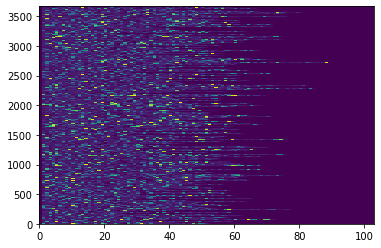

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

The input mask identifies where a sentence is padded, values of 1, represented by yellow in the graph demonstrate that the input is not padded while values of 0 represented as purple mean that the input is padding.

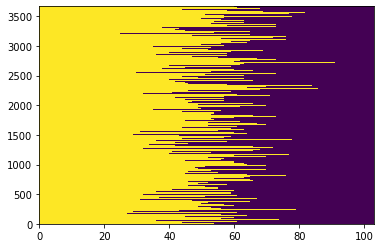

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

Input type IDs shows which sentence the token is part of within the padded region.

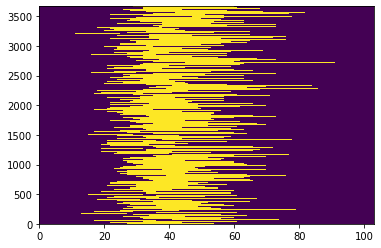

In [ ]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

The bert_encode function below does all the previously described pre-processing steps to create input_word_ids, input_mask, and input_type_ids.

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])

  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs


We can now apply the bert_encode function to the training, validation, and testing sets to complete pre-processing.

In [ ]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)

Below we that the shapes of the training input are all the same (3668 sentence pairs x 103 tokens) except for the labels.

In [ ]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


## Fine-tuning BERT

BERT stands for Bidirectional Encoder Representations from Transformers. It is an improvement over RNN and LSTM models as it processes words simultaneously using transformers making it faster. It also is truly bidirectional making it easier to learn the context of words. The pre-trained BERT model is made to understand language and context and therefore can be fine-tuned rather easily for a number of different language tasks. In this case, I am fine-tuning it to evaluate the semantic similarity of sentence pairs.

Here we download the configuration for the BERT model. We can also look at the details of the BERT configuration that we will fine-tine. For example, the model contains 12 hidden layers, a hidden size of 768, and 12 attention heads.

In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

Getting both the encoder and the classifier.

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

Here we see the architecture of the classifier which takes three inputs into the BERT encoder. The input_word_ids are the sentence pairs that are encoded, concatenated, and zero-padded. The input_mask allows the model to differentiate between the content and the padding. The input_type_ids indicate which sentence the token is a part of.

The BERT encoder feeds into a dropout layer and then finally into binary classification layers.

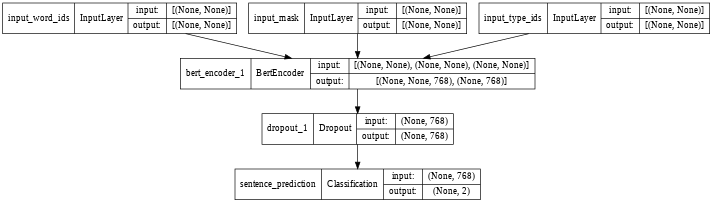

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

Below is an example of the output from the model which shows the values of the logit for each class.

In [ ]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[-0.19089556,  0.10488638],
       [-0.30230147,  0.08912799],
       [-0.24913529, -0.06032073],
       [-0.18892428,  0.00920337],
       [-0.15200296, -0.31648016],
       [-0.21627119,  0.02930921],
       [-0.35321808, -0.20366102],
       [-0.25105765, -0.09949163],
       [-0.34699938, -0.02090511],
       [-0.29710135, -0.0240919 ]], dtype=float32)

Now we can look specifically at the architecture of the BERT encoder. It consists of 12 transformer hidden layers of size 768. The encoder is connected to the aforementioned three input layers.

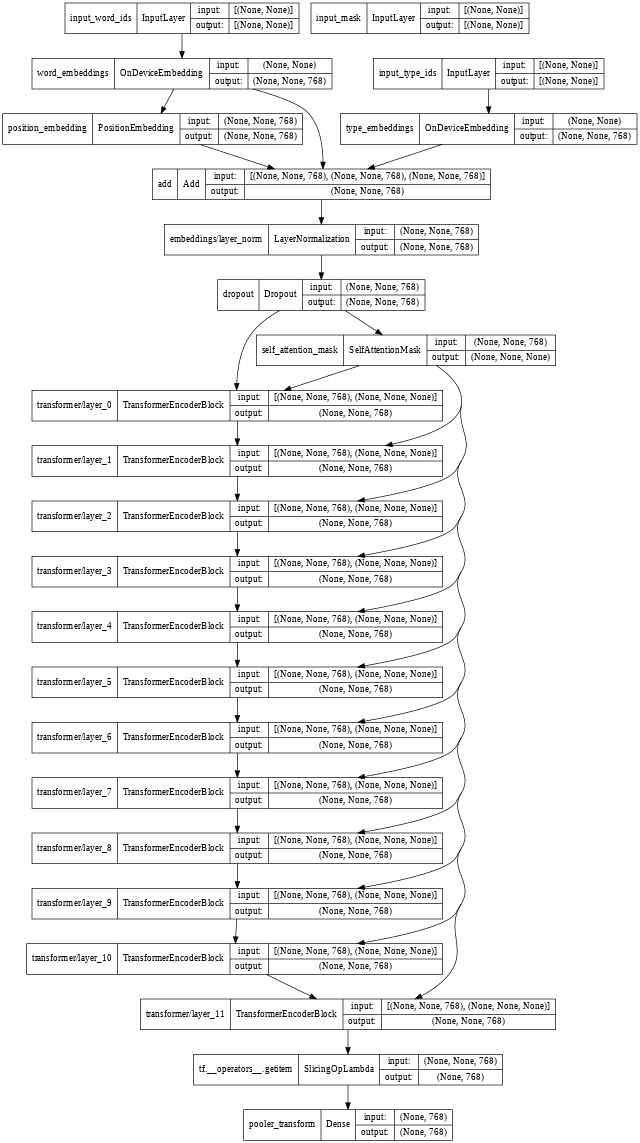

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

Restoring the trained weights for the encoder.

In [ ]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Now we can set up the model training hyper-parameters. The model uses an Adam optimizer with weight decay.  Also the model is set to train for three epochs. Since the only layer that needs to be trained are the ouput layers, the training time should be relatively quick.

In [ ]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

When training we use the sparse categorical cross-entropy for the loss function.

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)


Epoch 1/3
115/115 [==============================] - 65s 401ms/step - loss: 0.5838 - accuracy: 0.7067 - val_loss: 0.4872 - val_accuracy: 0.7745
Epoch 2/3
115/115 [==============================] - 44s 387ms/step - loss: 0.3879 - accuracy: 0.8321 - val_loss: 0.3887 - val_accuracy: 0.8162
Epoch 3/3
115/115 [==============================] - 44s 386ms/step - loss: 0.2517 - accuracy: 0.9065 - val_loss: 0.4010 - val_accuracy: 0.8260


I also wanted to experiment with reducing the learning rate and increasing the number of epochs to see if it improves the model accuracy.

In [ ]:
epochs = 10
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    1e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

history = bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)


Epoch 1/10
115/115 [==============================] - 61s 395ms/step - loss: 0.7183 - accuracy: 0.4926 - val_loss: 0.5763 - val_accuracy: 0.6912
Epoch 2/10
115/115 [==============================] - 44s 385ms/step - loss: 0.5318 - accuracy: 0.7266 - val_loss: 0.4987 - val_accuracy: 0.7770
Epoch 3/10
115/115 [==============================] - 45s 394ms/step - loss: 0.4161 - accuracy: 0.8100 - val_loss: 0.4640 - val_accuracy: 0.7794
Epoch 4/10
115/115 [==============================] - 44s 384ms/step - loss: 0.3150 - accuracy: 0.8735 - val_loss: 0.4600 - val_accuracy: 0.8088
Epoch 5/10
115/115 [==============================] - 44s 384ms/step - loss: 0.2411 - accuracy: 0.9111 - val_loss: 0.5192 - val_accuracy: 0.8235
Epoch 6/10
115/115 [==============================] - 44s 384ms/step - loss: 0.1886 - accuracy: 0.9378 - val_loss: 0.4710 - val_accuracy: 0.8260
Epoch 7/10
115/115 [==============================] - 44s 384ms/step - loss: 0.1465 - accuracy: 0.9550 - val_loss: 0.6452 - val_ac

After decreasing the learning rate and increasing the number of epochs trained, the validation accuracy peaks around the same value as before (82%) and then begins to decline slightly while the training accuracy steadily increases.

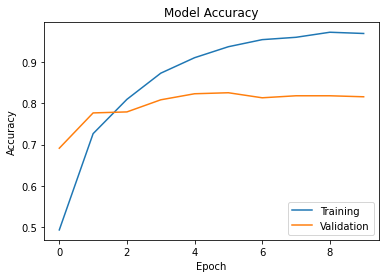

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Evaluating Performance

Before evaluating the test data I first wrote a few sentences pairs myself to see if the model could correctly classify them. The first two sentence pairs I made fairly easy while the second two pairs I tried to make a little more difficult. For sentence pair 3 I tried to convey the same sentiment while using mostly different words and in sentence pair 4 I tried to convey a different sentiment using the same words.

In [ ]:
my_example = bert_encode(
    glue_dict = {
        'sentence1':[
            'This sentence is written with the intention to match.',
            'Fine-tuning BERT can allow you identify similar sentiments.',
            'My dog ran away from me yesterday.',
            'I had the best week of my life during third grade.'],
        'sentence2':[
            'I am aiming to match the sentiment in the other sentence.',
            'This sentence has a different sentiment than the other sentence.',
            'My canine escaped last night.',
            'In third grade I tried to best myself week after week to no avail.']
    },
    tokenizer=tokenizer)

From my example sentences the model correctly classified 3 out of 4 sentences. The pair that is classified incorrectly was the fourth sentence pair where I tried to convey a different sentence using the same words. My guess is that it classified it incorrectly because the training data is taken from the news and none of the sentences are written with the intention of tricking an NLP model, therefore it may not perform well if people intentionally try to fool it.

In [ ]:
result = bert_classifier.predict(my_example)
result = tf.argmax(result, 1).numpy()
print(result)

[1 0 1 1]


In [ ]:
np.array(info.features['label'].names)[result]

array(['equivalent', 'not_equivalent', 'equivalent'], dtype='<U14')

The classification accuracy is 82.72%, however since this is binary classification looking at a confusion matrix would likely be a better indication of performance.

In [ ]:
bert_classifier.evaluate(glue_test, glue_test_labels)

54/54 [==============================] - 7s 128ms/step - loss: 0.4048 - accuracy: 0.8272


[0.4048013687133789, 0.827246367931366]

Here I get the vector of predictions.

In [ ]:
pred = bert_classifier.predict(glue_test)
pred = tf.argmax(pred, 1)

From the confusion matrix, we can see that approximately 67% (391/578) of the non-equivalent sentences were classified correctly while approximately 90% (1036/1147) of the equivalent sentences were classified correctly. This indicates that the model has a lot of room for improvement in classifying sentences that are not semantically equivalent. Perhaps training it on a dataset with a balanced number of labels would help.

In [ ]:
tf.math.confusion_matrix(glue_test_labels, pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 391,  187],
       [ 111, 1036]], dtype=int32)>

## Summary

While this model has some room for improvement, specifically in classifying sentences that are not equivalent, it is impressive that fine-tuning BERT reaches a relatively high level of accuracy on a new task in such a short amount of training time. The results from this model can also be compared to Johnny's results in training a version of ELECTRA on the same data.

ELECTRA differs from BERT in that it corrupts input tokens with plausible alternatives rather than masking inputs. In general this process is more efficient and ELECTRA outperforms BERT on the GLUE natural language understanding benchmark. On the MRPC, I achieved an accuracy of 82.72% while ELECTRA recieved an accuracy of 93.9%. The improved performance is consistent with the GLUE score results discussed in the paper "ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators".

Although BERT does not perform as well as some of the architectures that come after it, I believe it is still useful to understand as a lot of the concepts in BERT are helpful in understanding the architectures that come out of it. It's performance also serves as a useful baseline to compare to the other architectures.